In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard
import numpy as np
import os
import matplotlib.pyplot as plt

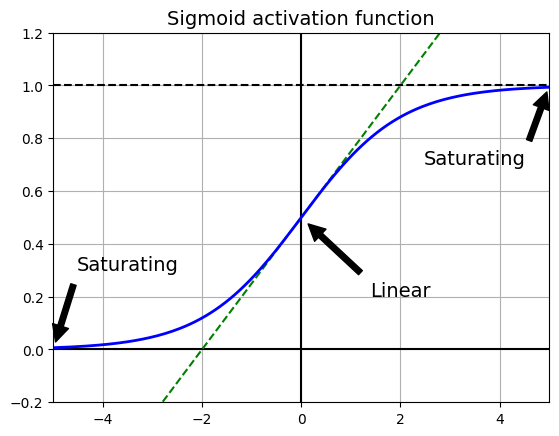

In [2]:
# 로지스틱 시그모이드 함수 시각화

def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

로지스틱 함수를 보면 양수나 음수로 입력값이 커지게 되면 출력값이 0이나 1로 수렴하게 된다.

그리고 이때의 기울기가 0에 매우 가까워지기 때문에 점점 세기가 약해져 실제 역전파가 될 때 아래쪽 층에는 아무것도 도달하지 않게 된다.

시그모이드 이러한 문제가 있기 때문에 수렴하지 않는 활성화 함수를 사용해 그레디언트의 소실을 방지해야한다.

수렴하지 않는 대표적인 활성화 함수로 ReLU가 있다.

하지만 ReLU는 훈련하는 동안 일부 뉴런이 0이외의 값을 출력하지 않는 죽은ReLU 문제가 있다.

따라서 음수일때 0이 아닌 작은 값을 가지는 LeakyReLU와 같은 ReLU의 변종을 사용한다.

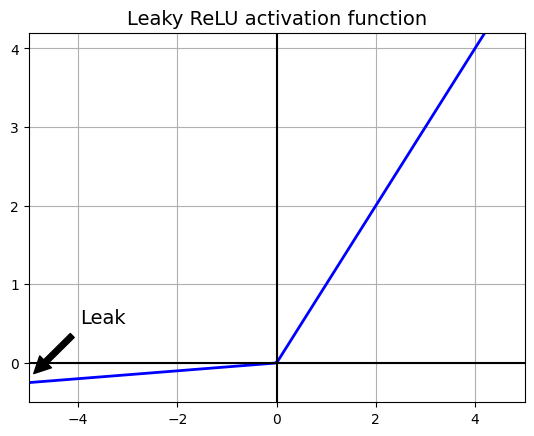

In [3]:
# LeakyReLU 함수 시각화

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

LeakyReLU로 MNIST데이터를 신경망 훈련해본다.

간단하게 은닉층 2개와 출력층 1개로 구성된 신경망을 만들었다.

활성화 함수는 은닉층의 뒤에 추가하면 된다.

In [4]:
# LeakyReLU로 MNIST데이터 신경망 훈련

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [5]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.2542 - accuracy: 0.6130 - val_loss: 0.8670 - val_accuracy: 0.7152
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7871 - accuracy: 0.7346 - val_loss: 0.7094 - val_accuracy: 0.7676
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6805 - accuracy: 0.7733 - val_loss: 0.6357 - val_accuracy: 0.7914
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6223 - accuracy: 0.7926 - val_loss: 0.5905 - val_accuracy: 0.8072
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5835 - accuracy: 0.8053 - val_loss: 0.5586 - val_accuracy: 0.8188
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5554 - accuracy: 0.8147 - val_loss: 0.5377 - val_accuracy: 0.8264
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5340 - accuracy: 0.8208 - val_loss: 0.5177 - val_accuracy:

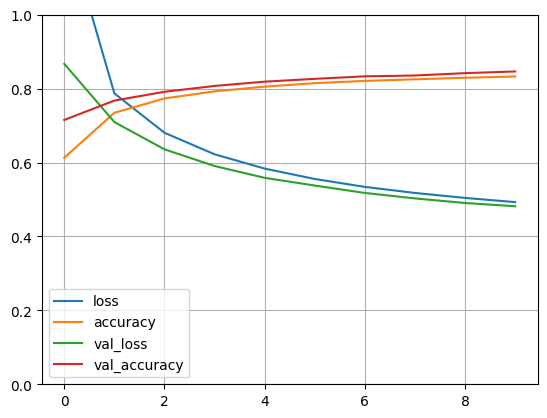

In [8]:
import pandas as pd

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

PReLU는 ReLU의 변형 중 하나로, 음수 입력 값에 대해 더 복잡한 조정을 수행하는 특징이 있다.

양수에 대해서는 ReLU와 같은 값을 가지고, 음수 입력에 대해서는 학습 가능한 파라미터를 사용하여 조정한다.

따라서 PReLU는 신경망에서 입력 데이터에 대한 다양한 조정을 수행하여 데이터의 특징을 더 효과적으로 표현할 수 있게된다.

In [9]:
# PReLU를 사용해 훈련

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [10]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 1.3892 - accuracy: 0.5818 - val_loss: 0.9308 - val_accuracy: 0.7048
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8266 - accuracy: 0.7338 - val_loss: 0.7276 - val_accuracy: 0.7636
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6953 - accuracy: 0.7766 - val_loss: 0.6448 - val_accuracy: 0.7884
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6299 - accuracy: 0.7952 - val_loss: 0.5942 - val_accuracy: 0.8062
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5878 - accuracy: 0.8076 - val_loss: 0.5607 - val_accuracy: 0.8158
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5581 - accuracy: 0.8152 - val_loss: 0.5342 - val_accuracy: 0.8232
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5359 - accuracy: 0.8218 - val_loss: 0.5196 - val_accuracy:

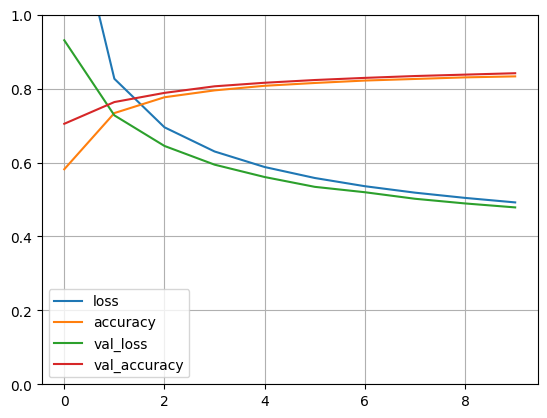

In [11]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

ELU는 음수가 입력되면 음수값이 들어오므로 평균 출력이 0에 더 가까워 지고, 그레디언트가 0이 아니여서 죽은 뉴런을 만들지 않는다.

그리고 알파값이 1이면 0에서 함수값이 급변하지 않아 모든 구간에서 매끄럽기 때문에 경사하강법의 속도가 높아지게 된다.

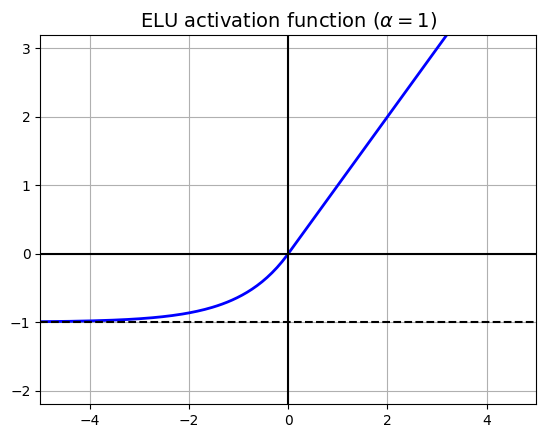

In [12]:
# ELU함수 시각화

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.0939 - accuracy: 0.6651 - val_loss: 0.7594 - val_accuracy: 0.7568
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7041 - accuracy: 0.7695 - val_loss: 0.6407 - val_accuracy: 0.7916
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6219 - accuracy: 0.7931 - val_loss: 0.5846 - val_accuracy: 0.8050
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5775 - accuracy: 0.8057 - val_loss: 0.5505 - val_accuracy: 0.8174
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5484 - accuracy: 0.8139 - val_loss: 0.5266 - val_accuracy: 0.8286
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5273 - accuracy: 0.8204 - val_loss: 0.5101 - val_accuracy: 0.8324
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5117 - accuracy: 0.8244 - val_loss: 0.4953 - val_accuracy:

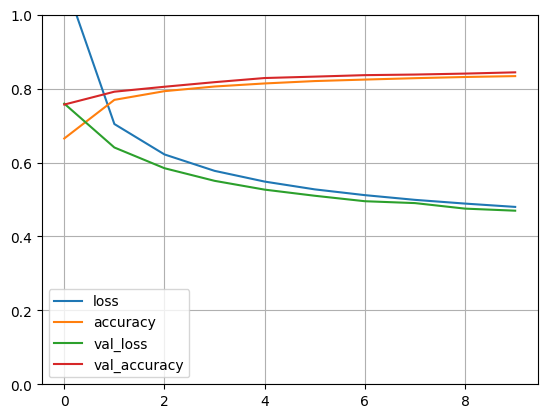

In [15]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

완전 연결 층만 쌓아서 신경망을 만들고 모든 은닉층이 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화된다.

훈련하는 도중 각 층의 출력이 평균과 표준편차를 보존하는 경향이 있어 그레이디언트 소실과 폭주 문제를 막아준다.

하지만 $L_1, L_2$정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지등을 사용하면 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨지는 문제가 있다.

In [16]:
# alpha와 scale 평균 0, 표준 편차 1로 자기 정규화

from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

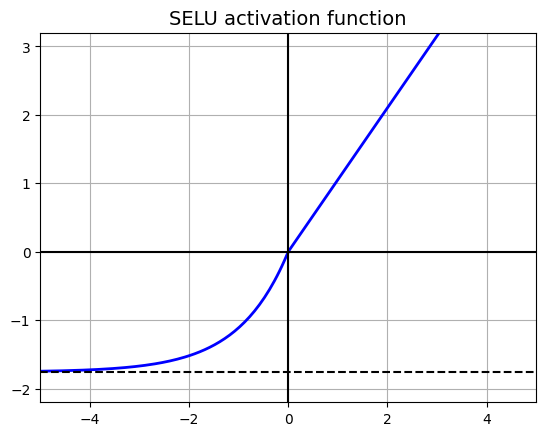

In [17]:
# selu 시각화

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [18]:
# selu를 사용하면 평균이 0에 가깝고 표준편차는 1에 가깝게 나옴을 확인

Z = np.random.normal(size=(500, 100))
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.03, std deviation 0.91
Layer 200: mean -0.06, std deviation 0.90
Layer 300: mean -0.01, std deviation 0.89
Layer 400: mean 0.01, std deviation 0.98
Layer 500: mean 0.10, std deviation 0.84
Layer 600: mean -0.02, std deviation 0.92
Layer 700: mean -0.05, std deviation 0.89
Layer 800: mean 0.01, std deviation 0.93
Layer 900: mean 0.02, std deviation 0.91


In [19]:
# 100개의 은닉층과 SELU 활성화 함수를 사용해 패션 MNIST 학습

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [20]:
# 학습 하기 위해서 입력을 평균 0, 표준편차 1로 변환

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 47s 22ms/step - loss: 1.0435 - accuracy: 0.6183 - val_loss: 0.7655 - val_accuracy: 0.7360
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.6986 - accuracy: 0.7505 - val_loss: 0.6121 - val_accuracy: 0.7834
Epoch 3/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.9550 - accuracy: 0.6320 - val_loss: 1.0106 - val_accuracy: 0.5998
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.7741 - accuracy: 0.7181 - val_loss: 0.6529 - val_accuracy: 0.7708
Epoch 5/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.6172 - accuracy: 0.7803 - val_loss: 0.5694 - val_accuracy: 0.7862


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 보죠:

In [22]:
# selu 대신 ReLU 사용하여 비교

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 42s 18ms/step - loss: 2.0051 - accuracy: 0.2190 - val_loss: 1.7516 - val_accuracy: 0.3234
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 1.4962 - accuracy: 0.3837 - val_loss: 1.0463 - val_accuracy: 0.5540
Epoch 3/5
1719/1719 [==============================] - 30s 17ms/step - loss: 1.1683 - accuracy: 0.5097 - val_loss: 0.9422 - val_accuracy: 0.6052
Epoch 4/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.8914 - accuracy: 0.6295 - val_loss: 0.7767 - val_accuracy: 0.6944
Epoch 5/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.8755 - accuracy: 0.6692 - val_loss: 0.9584 - val_accuracy: 0.7018


그레이디언트 폭주나 소실 문제가 발생하여 ReLU보다 selu값이 좋은 것을 볼 수 있다.

In [24]:
# 배치 정규화

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [25]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_211 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_212 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

요약에서 볼 수 있다시피 배치 정규화층은 입력마다 네 개의 $\gamma, \beta, \mu, \sigma$파라미터를 추가한다. (ex 784 * 4 = 3136)

여기서 $\mu, \sigma$는 이동 평균과 분산으로 역전파 학습에 사용되지 않기때문에 Non-trainable params로 분류된다.

In [26]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8433 - accuracy: 0.7226 - val_loss: 0.5508 - val_accuracy: 0.8136
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5685 - accuracy: 0.8062 - val_loss: 0.4723 - val_accuracy: 0.8358
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5085 - accuracy: 0.8258 - val_loss: 0.4404 - val_accuracy: 0.8478
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4759 - accuracy: 0.8355 - val_loss: 0.4169 - val_accuracy: 0.8540
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4491 - accuracy: 0.8435 - val_loss: 0.4038 - val_accuracy: 0.8576
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4324 - accuracy: 0.8484 - val_loss: 0.3906 - val_accuracy: 0.8612
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4212 - accuracy: 0.8519 - val_loss: 0.3811 - val_accuracy

BatchNormalization층이 이전 층의 편향을 무효화 하기 때문에 이전의 편향을 위한 항은 필요가 없다.

따라서 use_bias=False로 하고 활성함수를 따로 써서 훈련할 수도 있다.

In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [28]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0481 - accuracy: 0.6737 - val_loss: 0.6654 - val_accuracy: 0.7874
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6769 - accuracy: 0.7823 - val_loss: 0.5465 - val_accuracy: 0.8230
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5893 - accuracy: 0.8062 - val_loss: 0.4932 - val_accuracy: 0.8370
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5426 - accuracy: 0.8177 - val_loss: 0.4603 - val_accuracy: 0.8454
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5112 - accuracy: 0.8271 - val_loss: 0.4366 - val_accuracy: 0.8532
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4895 - accuracy: 0.8331 - val_loss: 0.4190 - val_accuracy: 0.8588
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4701 - accuracy: 0.8377 - val_loss: 0.4080 - val_accura

### 사전 훈련층 재사용

패션 MNIST데이터 중에서 셔츠와 샌달을 제외한 데이터로 학습을 먼저 진행한다.

학습에 사용된 데이터와 학습에서 제외되었던 센달과 셔츠 데이터는 유사성이 높기 때문에 학습한 모델을 재사용하면 모델의 지식이 전달될 가능성이 높다.

In [29]:
# 패션 MNIST에서 샌달과 셔츠 데이터 분리

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6)
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2
    y_B = (y[y_5_or_6] == 6).astype(np.float32)
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [30]:
# 셔츠와 샌달없는 데이터 학습

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [31]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.5542 - accuracy: 0.8181 - val_loss: 0.3682 - val_accuracy: 0.8714
Epoch 2/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3534 - accuracy: 0.8790 - val_loss: 0.3150 - val_accuracy: 0.8901
Epoch 3/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3171 - accuracy: 0.8909 - val_loss: 0.2940 - val_accuracy: 0.8936
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2977 - accuracy: 0.8975 - val_loss: 0.2794 - val_accuracy: 0.9001
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2840 - accuracy: 0.9026 - val_loss: 0.2742 - val_accuracy: 0.9011
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2733 - accuracy: 0.9069 - val_loss: 0.2636 - val_accuracy: 0.9041
Epoch 7/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2654 - accuracy: 0.9095 - val_loss: 0.2717 - val_accuracy:

In [37]:
# 학습한 모델 저장

model_A.save("my_model_A.keras")

In [33]:
# 사전학습 없이 샌달과 셔츠 학습

model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [34]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 2s 77ms/step - loss: 0.4682 - accuracy: 0.6900 - val_loss: 0.4031 - val_accuracy: 0.8306
Epoch 2/20
7/7 [==============================] - 0s 28ms/step - loss: 0.3599 - accuracy: 0.8800 - val_loss: 0.3368 - val_accuracy: 0.9097
Epoch 3/20
7/7 [==============================] - 0s 29ms/step - loss: 0.2992 - accuracy: 0.9450 - val_loss: 0.2930 - val_accuracy: 0.9442
Epoch 4/20
7/7 [==============================] - 0s 30ms/step - loss: 0.2583 - accuracy: 0.9650 - val_loss: 0.2642 - val_accuracy: 0.9473
Epoch 5/20
7/7 [==============================] - 0s 30ms/step - loss: 0.2302 - accuracy: 0.9750 - val_loss: 0.2376 - val_accuracy: 0.9574
Epoch 6/20
7/7 [==============================] - 0s 30ms/step - loss: 0.2059 - accuracy: 0.9750 - val_loss: 0.2166 - val_accuracy: 0.9635
Epoch 7/20
7/7 [==============================] - 0s 29ms/step - loss: 0.1860 - accuracy: 0.9750 - val_loss: 0.2002 - val_accuracy: 0.9665
Epoch 8/20
7/7 [===========

In [35]:
model_B.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_223 (Dense)           (None, 300)               235500    
                                                                 
 dense_224 (Dense)           (None, 100)               30100     
                                                                 
 dense_225 (Dense)           (None, 50)                5050      
                                                                 
 dense_226 (Dense)           (None, 50)                2550      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 1)                

첫 번째 모델을 학습한 결과 약 92%의 정확도를 얻었다.

그리고 해당 모델을 저장하였다.

두 번째 모델을 학습한 결과는 약 97%의 매우 높은 정확도를 얻었다.

하지만 더 높은 정확도를 위해 첫 번째 모델의 학습 결과를 불러와 사전학습으로 사용하여 더 높은 정확도를 얻겠다.

주의해야할 점은 여기서 model_B_on_A와 model_A는 같은층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트된다.

따라서 이를 피하려면 model_A를 클론한 것을 사용해 model_B_on_A를 만들어야 한다

사전학습을 사용할때 초반에는 새로운 출력층이 랜덤하게 초기화 되어있으므로 큰 오차를 만든다.

그렇기 때문에 초반에는 재사용된 층을 동결하여 새로운 층에게 적절한 가중치를 학습할 시간을 주는것이 필요하다.

In [51]:
# 사전학습 모델 불러와서 사전학습하기

model_A = keras.models.load_model("my_model_A.h5")
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [52]:
# 적절한 가중치 학습을 위한 재사용층 동결

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [53]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# 일정시간 후에 동결을 해제한다.
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 52ms/step - loss: 0.6052 - accuracy: 0.7050 - val_loss: 0.6637 - val_accuracy: 0.6957
Epoch 2/4
7/7 [==============================] - 0s 21ms/step - loss: 0.5688 - accuracy: 0.7050 - val_loss: 0.6277 - val_accuracy: 0.7120
Epoch 3/4
7/7 [==============================] - 0s 20ms/step - loss: 0.5351 - accuracy: 0.7250 - val_loss: 0.5949 - val_accuracy: 0.7302
Epoch 4/4
7/7 [==============================] - 0s 28ms/step - loss: 0.5044 - accuracy: 0.7600 - val_loss: 0.5639 - val_accuracy: 0.7475
Epoch 1/16
7/7 [==============================] - 1s 57ms/step - loss: 0.3610 - accuracy: 0.8450 - val_loss: 0.3067 - val_accuracy: 0.8895
Epoch 2/16
7/7 [==============================] - 0s 21ms/step - loss: 0.2091 - accuracy: 0.9450 - val_loss: 0.2385 - val_accuracy: 0.9199
Epoch 3/16
7/7 [==============================] - 0s 20ms/step - loss: 0.1580 - accuracy: 0.9700 - val_loss: 0.1959 - val_accuracy: 0.9442
Epoch 4/16
7/7 [===============

In [54]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.1024 - accuracy: 0.9855


[0.10241422802209854, 0.9854999780654907]

In [55]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0758 - accuracy: 0.9785


[0.07575176656246185, 0.9785000085830688]

### 거듭제곱 스케줄링

$lr = \frac{lr_0}{(1 + \frac{t}{s})^c}$ 

s는 스텝 횟수이고, c는 거듭제곱수로 일반적으로 1을 사용한다.

학습률을 초반엔 빠르게 줄어들다가 점점 느리게 감소하게 된다.

In [64]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [65]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4836 - accuracy: 0.8285 - val_loss: 0.4133 - val_accuracy: 0.8526
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3790 - accuracy: 0.8649 - val_loss: 0.3743 - val_accuracy: 0.8712
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3445 - accuracy: 0.8761 - val_loss: 0.3647 - val_accuracy: 0.8718
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3229 - accuracy: 0.8840 - val_loss: 0.3483 - val_accuracy: 0.8812
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3047 - accuracy: 0.8897 - val_loss: 0.3518 - val_accuracy: 0.8744
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2895 - accuracy: 0.8952 - val_loss: 0.3397 - val_accuracy: 0.8808
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2760 - accuracy: 0.8996 - val_loss: 0.3473 - val_accuracy:

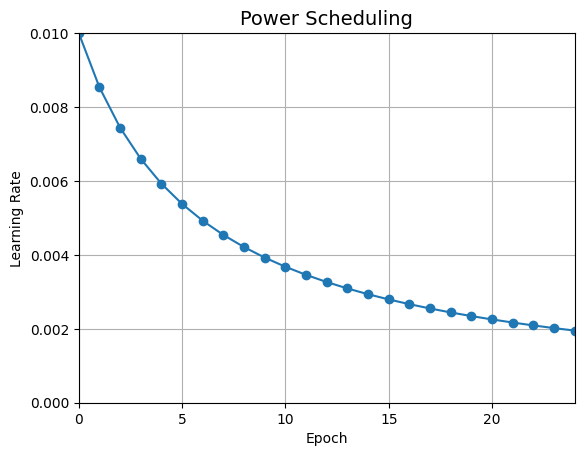

In [66]:
# 거듭제곱 스케줄링의 시간에 따른 학습률

import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

$lr = lr_0  0.1^{\frac{t}{s}}$

학습률이 스텝s마다 10배씩 점차 줄어든다.

거듭제곱 기반 스케줄링보다 빠른 속도로 학습률이 감소한다.

In [67]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [68]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [69]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.7659 - accuracy: 0.7754 - val_loss: 0.7609 - val_accuracy: 0.7728 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6482 - accuracy: 0.8029 - val_loss: 0.5944 - val_accuracy: 0.8310 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5747 - accuracy: 0.8238 - val_loss: 0.8242 - val_accuracy: 0.8228 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5594 - accuracy: 0.8285 - val_loss: 0.6100 - val_accuracy: 0.8402 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4956 - accuracy: 0.8475 - val_loss: 0.7352 - val_accuracy: 0.8224 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4676 - accuracy: 0.8543 - val_loss: 0.5409 - val_accuracy: 0.8488 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 

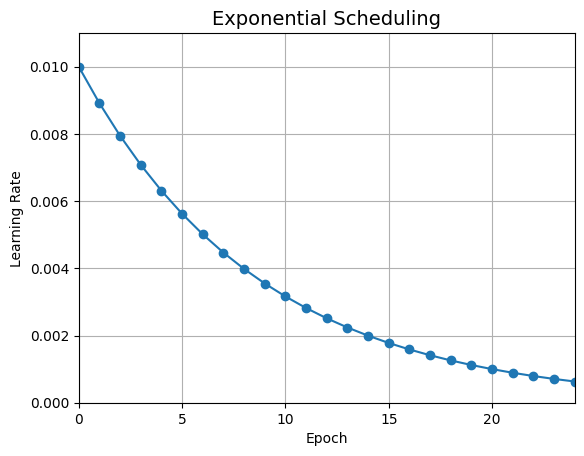

In [70]:
# 지수 기반 스케줄링의 시간에 따른 학습률

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [71]:
# 에포크가 아닌 반복마다 학습률 업데이트

K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25


# 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
s = 20 * len(X_train) // 32 
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7191 - accuracy: 0.7821 - val_loss: 0.6101 - val_accuracy: 0.8142 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6124 - accuracy: 0.8112 - val_loss: 0.4915 - val_accuracy: 0.8444 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5596 - accuracy: 0.8279 - val_loss: 0.6435 - val_accuracy: 0.8184 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5086 - accuracy: 0.8426 - val_loss: 0.6574 - val_accuracy: 0.7846 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4729 - accuracy: 0.8527 - val_loss: 0.4805 - val_accuracy: 0.8496 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4292 - accuracy: 0.8651 - val_loss: 0.5647 - val_accuracy: 0.8434 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] -

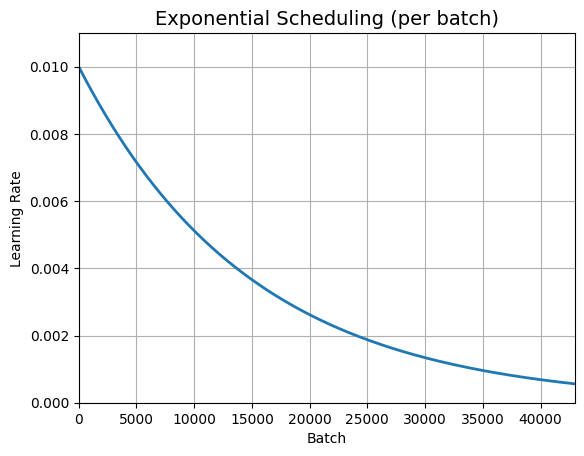

In [72]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 기간별 고정 스케줄링

함수를 따로 사용하는 대신 사용자가 임의로 설정한 스케줄링을 바탕으로 학습을 한다.

이러한 방식은 잘 동작할 수 있지만 적절한 값을 찾는데 많은 시행착오가 발생한다.

아래에는 에포크가 5미만이면 0.01로, 15미만이면 0.005로 그 이후면 0.001로 설정하였다.

In [73]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [74]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 5ms/step - loss: 0.7240 - accuracy: 0.7875 - val_loss: 0.7638 - val_accuracy: 0.7860 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7223 - accuracy: 0.7885 - val_loss: 1.1957 - val_accuracy: 0.7070 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7772 - accuracy: 0.7855 - val_loss: 1.0530 - val_accuracy: 0.7246 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7943 - accuracy: 0.7749 - val_loss: 0.7908 - val_accuracy: 0.7866 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7948 - accuracy: 0.7745 - val_loss: 0.9555 - val_accuracy: 0.6874 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5896 - accuracy: 0.8177 - val_loss: 0.6570 - val_accuracy: 0.8304 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 9

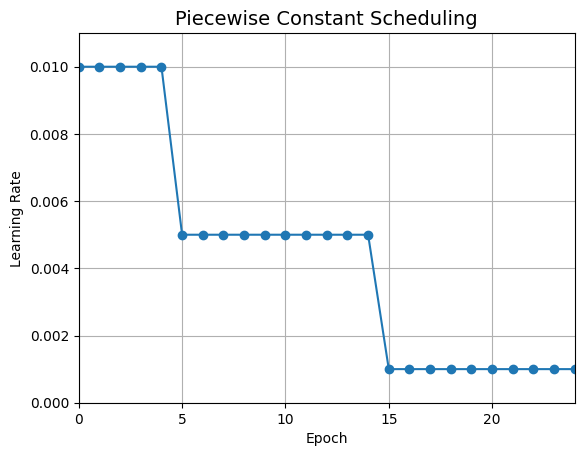

In [75]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 성능 기반 스케줄링

N스텝마다 검증 오차를 측정하고 오차가 줄어들지 않으면 학습률을 감소시키는 방식이다.

In [76]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5956 - accuracy: 0.8047 - val_loss: 0.4494 - val_accuracy: 0.8370 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5093 - accuracy: 0.8366 - val_loss: 0.6242 - val_accuracy: 0.8242 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5041 - accuracy: 0.8424 - val_loss: 0.4458 - val_accuracy: 0.8596 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5029 - accuracy: 0.8485 - val_loss: 0.5614 - val_accuracy: 0.8438 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5060 - accuracy: 0.8536 - val_loss: 0.6364 - val_accuracy: 0.8344 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5431 - accuracy: 0.8493 - val_loss: 0.6676 - val_accuracy: 0.8276 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 7s

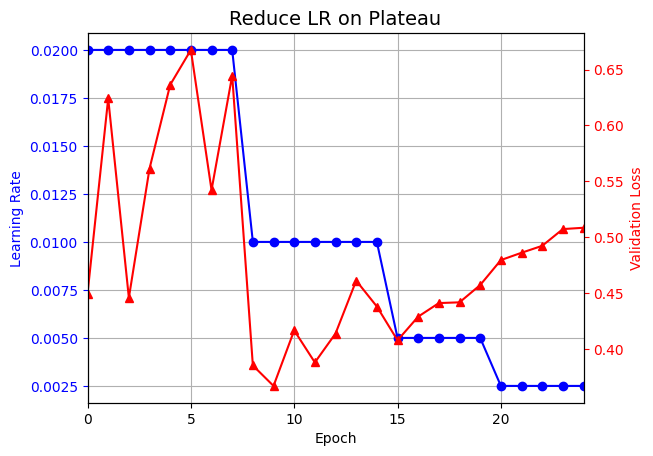

In [77]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1사이클 스케줄링

훈련 절반 동안 초기 학습률 $\eta_0$을 선형적으로$\eta_1$까지 증가시킨다.

그 후 나머지 절반 동안 선형적으로 학습률을 다시 $\eta_0$까지 줄인다.

최대 학습률인$\eta_1$는 최적의 학습률을 찾을 때와 같은 방법으로 찾고, $\eta_0$은 찾은 값의 0.1배정도의 값으로 정한다.

In [78]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [79]:
# 최적의 학습률 구하기

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.3599


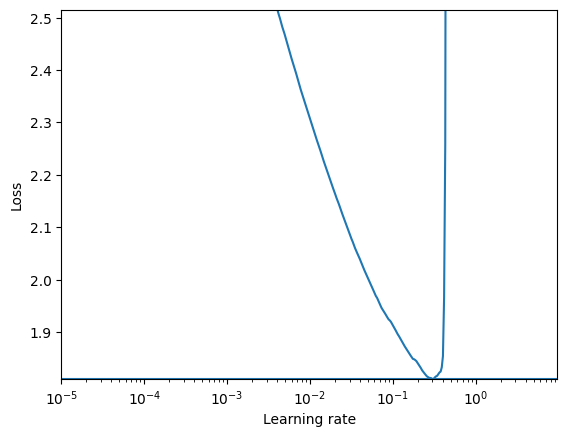

In [80]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [81]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [82]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.6658 - accuracy: 0.7695 - val_loss: 0.4872 - val_accuracy: 0.8342
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4598 - accuracy: 0.8398 - val_loss: 0.4261 - val_accuracy: 0.8600
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4135 - accuracy: 0.8559 - val_loss: 0.4013 - val_accuracy: 0.8604
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3847 - accuracy: 0.8658 - val_loss: 0.3816 - val_accuracy: 0.8674
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3634 - accuracy: 0.8712 - val_loss: 0.3684 - val_accuracy: 0.8714
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3446 - accuracy: 0.8783 - val_loss: 0.3677 - val_accuracy: 0.8674
Epoch 7/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3290 - accuracy: 0.8825 - val_loss: 0.3501 - val_accuracy: 0.8774
Epoch 

In [83]:
# L1 & L2규제 - L2규제 사용

layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 1.6033 - accuracy: 0.8135 - val_loss: 0.7399 - val_accuracy: 0.8178
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7225 - accuracy: 0.8259 - val_loss: 0.6782 - val_accuracy: 0.8492


In [85]:
# 드롭아웃

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5636 - accuracy: 0.8036 - val_loss: 0.3570 - val_accuracy: 0.8698
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4174 - accuracy: 0.8485 - val_loss: 0.3686 - val_accuracy: 0.8654


### 알파 드롭아웃

알파 드롭아웃은 드롭아웃의 변종의 하나로 SELU화렁화 함수를 기반으로 자기 정규화하는 네트워크를 규제한다.

이는 입력의 평균과 표준편차를 유지하는 드롭아웃이다.

In [86]:
# 알파 드롭아웃

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6612 - accuracy: 0.7574 - val_loss: 0.6061 - val_accuracy: 0.8342
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5549 - accuracy: 0.7947 - val_loss: 0.5195 - val_accuracy: 0.8554
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5249 - accuracy: 0.8041 - val_loss: 0.5344 - val_accuracy: 0.8548
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5060 - accuracy: 0.8127 - val_loss: 0.4731 - val_accuracy: 0.8546
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4927 - accuracy: 0.8187 - val_loss: 0.4729 - val_accuracy: 0.8596
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4838 - accuracy: 0.8215 - val_loss: 0.5354 - val_accuracy: 0.8616
Epoch 7/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4659 - accuracy: 0.8275 - val_loss: 0.4535 - val_accuracy:

### 몬테 카를로 드롭아웃

드롭아웃은 모델 훈련 중에 뉴런의 활성화를 무작위로 끄고 다시 켜면서 과적합을 줄이게 된다.

MC Dropout은 이 아이디어를 확장하여 모델의 예측 불확실성을 추정하는 데 활용한다.

모델을 드롭아웃으로 훈련한 후, 예측을 수행할 때 몬테 카를로 드롭아웃 활성화합니다.

이는 예측 과정에서 드롭아웃을 다시 활성화하여 모델의 예측 불확실성을 추정합니다.

In [87]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [88]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [89]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaD  (None, 784)               0         
 ropout)                                                         
                                                                 
 dense_258 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlph  (None, 300)               0         
 aDropout)                                                       
                                                                 
 dense_259 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlph  (None, 100)             

In [90]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [91]:
mc_model.set_weights(model.get_weights())

In [93]:
# 맥스-노름 규제

from functools import partial

layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 4ms/step - loss: 0.4749 - accuracy: 0.8343 - val_loss: 0.3956 - val_accuracy: 0.8616
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3615 - accuracy: 0.8683 - val_loss: 0.3640 - val_accuracy: 0.8698
